In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime

W1102 18:20:04.883356 43072 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1102 18:20:04.911357 43072 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob, chalie, dave]
frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
def generateLoadersPerClass(dataset):
    #loaders per class
    loaders_per_class = []
    for class_name in dataset.classes:
        # get the indices in the dataset that are relative to that class
        idx = [
            pos for pos, item in enumerate(dataset.samples)
            if item[1] == dataset.class_to_idx[class_name]]
        # construct the corresponding dataloader thanks to a SubsetRandomSampler
        loaders_per_class += [torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=SubsetRandomSampler(idx),
            **kwargs)]
    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign data
yalefaces = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original',
                             transform=data_transform)
original_loaders = generateLoadersPerClass(yalefaces)

#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original_test',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)

# Load backdoor dataset

In [6]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses',
                             transform=data_transform)
#malicious data
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loaders = generateLoadersPerClass(backdoored)


#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses_test',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]
dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

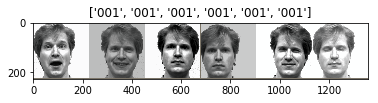

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = yalefaces.classes
# Get a batch of training data
inputs, classes = next(iter(original_loaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Send dataset to clients

In [9]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#EACH CLIENT KNOWS EACH CLASS
#normal clients
for loader in original_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                train_distributed_dataset.append((data_append, target_append))

#backdoored clients
for loader in backdoored_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
                target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
                train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [10]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
                100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [11]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
           for data, target in test_loader:
               data, target = data.to(device), target.to(device)
               output = model(data)
               test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
               pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
               correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [12]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented70.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_faces_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
csv_header += "#way backdoor looks like: " + "glasses" + "\n"
csv_header += "#order of time: " + "backdoors first" + "\n"
csv_header += "#attack model: " + "basic" + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 500):
    csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train backdoor
    avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_backdoor = datetime.datetime.now().strftime("%H%M%S")
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"
    timestamp_normal = datetime.datetime.now().strftime("%H%M%S")

    #save after each 10 iterations
    if epoch % 10 == 0:
        torch.save(model.state_dict(), ("exp_faces_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    test_loss, acc = test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc
    
    #test normal
    test_loss, acc = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc

    #scheduler.step(test_loss)
    
    #timestamp
    csv_normal += timestamp_normal + "\n"
    csv_backdoor += timestamp_backdoor + "\n"
    
    #Write to file
    f= open(("exp_faces_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()

    



#merge strategy: sequential
#number of distributed sources: 5
#batch size: 10
#distribution of data: equally distributed subset
#percentage of backdoored nodes: 0.2
#percentage of poisoned data in backdoored nodes: 100
#way backdoor looks like: glasses
#order of time: backdoors first
#attack model: basic
#starttime: 182112
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Train Epoch: 1 [0/30 (0%)]	Loss: 2.566299
Train Epoch: 1 [10/30 (33%)]	Loss: 2.545871
Train Epoch: 1 [20/30 (67%)]	Loss: 2.524189
Average training loss: 2.5454530715942383
Train Epoch: 1 [0/130 (0%)]	Loss: 2.579247
Train Epoch: 1 [10/130 (8%)]	Loss: 2.569242
Train Epoch: 1 [20/130 (15%)]	Loss: 2.572962
Train Epoch: 1 [30/130 (23%)]	Loss: 2.510638
Train Epoch: 1 [40/130 (31%)]	Loss: 2.594617
Train Epoch: 1 [50/130 (38%)]	Loss: 2.581201
Train Epoch: 1 [60/130 (46%)]	Loss: 2.565934
Train Epoch: 1 [70/130 (54%)]	Loss: 2.577229
Train Epoch: 1 [80/130 (62%)]	Loss: 2.583948
Train 

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 4 [0/30 (0%)]	Loss: 2.382188
Train Epoch: 4 [10/30 (33%)]	Loss: 2.346493
Train Epoch: 4 [20/30 (67%)]	Loss: 2.301223
Average training loss: 2.34330153465271
Train Epoch: 4 [0/130 (0%)]	Loss: 2.603626
Train Epoch: 4 [10/130 (8%)]	Loss: 2.596689
Train Epoch: 4 [20/130 (15%)]	Loss: 2.597774
Train Epoch: 4 [30/130 (23%)]	Loss: 2.308003
Train Epoch: 4 [40/130 (31%)]	Loss: 2.628626
Train Epoch: 4 [50/130 (38%)]	Loss: 2.612530
Train Epoch: 4 [60/130 (46%)]	Loss: 2.603735
Train Epoch: 4 [70/130 (54%)]	Loss: 2.605640
Train Epoch: 4 [80/130 (62%)]	Loss: 2.612010
Train Epoch: 4 [90/130 (69%)]	Loss: 2.604352
Train Epoch: 4 [100/130 (77%)]	Loss: 2.605267
Train Epoch: 4 [110/130 (85%)]	Loss: 2.615979
Train Epoch: 4 [120/130 (92%)]	Loss: 2.617429
Average training loss: 2.585512399673462

Test set: Average loss: 2.3014, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 

Train Epoch: 7 [20/30 (67%)]	Loss: 1.879819
Average training loss: 2.033440589904785
Train Epoch: 7 [0/130 (0%)]	Loss: 2.691434
Train Epoch: 7 [10/130 (8%)]	Loss: 2.651257
Train Epoch: 7 [20/130 (15%)]	Loss: 2.691083
Train Epoch: 7 [30/130 (23%)]	Loss: 1.924883
Train Epoch: 7 [40/130 (31%)]	Loss: 2.706615
Train Epoch: 7 [50/130 (38%)]	Loss: 2.721182
Train Epoch: 7 [60/130 (46%)]	Loss: 2.693117
Train Epoch: 7 [70/130 (54%)]	Loss: 2.697319
Train Epoch: 7 [80/130 (62%)]	Loss: 2.690748
Train Epoch: 7 [90/130 (69%)]	Loss: 2.675781
Train Epoch: 7 [100/130 (77%)]	Loss: 2.680935
Train Epoch: 7 [110/130 (85%)]	Loss: 2.680569
Train Epoch: 7 [120/130 (92%)]	Loss: 2.678850
Average training loss: 2.629521131515503

Test set: Average loss: 2.1219, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Train Epoch: 10 [30/130 (23%)]	Loss: 1.823624
Train Epoch: 10 [40/130 (31%)]	Loss: 2.571603
Train Epoch: 10 [50/130 (38%)]	Loss: 2.717003
Train Epoch: 10 [60/130 (46%)]	Loss: 2.728204
Train Epoch: 10 [70/130 (54%)]	Loss: 2.716171
Train Epoch: 10 [80/130 (62%)]	Loss: 2.729023
Train Epoch: 10 [90/130 (69%)]	Loss: 2.722997
Train Epoch: 10 [100/130 (77%)]	Loss: 2.709373
Train Epoch: 10 [110/130 (85%)]	Loss: 2.716300
Train Epoch: 10 [120/130 (92%)]	Loss: 2.713564
Average training loss: 2.6261050701141357

Test set: Average loss: 2.0748, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

Train Epoch: 13 [60/130 (46%)]	Loss: 2.728070
Train Epoch: 13 [70/130 (54%)]	Loss: 2.717801
Train Epoch: 13 [80/130 (62%)]	Loss: 2.742233
Train Epoch: 13 [90/130 (69%)]	Loss: 2.721004
Train Epoch: 13 [100/130 (77%)]	Loss: 2.737685
Train Epoch: 13 [110/130 (85%)]	Loss: 2.740357
Train Epoch: 13 [120/130 (92%)]	Loss: 2.732042
Average training loss: 2.6181187629699707

Test set: Average loss: 2.0319, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

Train Epoch: 16 [90/130 (69%)]	Loss: 2.728673
Train Epoch: 16 [100/130 (77%)]	Loss: 2.754162
Train Epoch: 16 [110/130 (85%)]	Loss: 2.758343
Train Epoch: 16 [120/130 (92%)]	Loss: 2.750145
Average training loss: 2.6176440715789795

Test set: Average loss: 1.9880, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

Train Epoch: 19 [120/130 (92%)]	Loss: 2.757774
Average training loss: 2.616513252258301

Test set: Average loss: 1.9468, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5824, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 26 [0/30 (0%)]	Loss: 1.876985
Train Epoch: 26 [10/30 (33%)]	Loss: 1.792811
Train Epoch: 26 [20/30 (67%)]	Loss: 1.68092

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 29 [0/30 (0%)]	Loss: 1.838927
Train Epoch: 29 [10/30 (33%)]	Loss: 1.757799
Train Epoch: 29 [20/30 (67%)]	Loss: 1.644464
Average training loss: 1.747063398361206
Train Epoch: 29 [0/130 (0%)]	Loss: 2.665847
Train Epoch: 29 [10/130 (8%)]	Loss: 2.707101
Train Epoch: 29 [20/130 (15%)]	Loss: 2.726183
Train Epoch: 29 [30/130 (23%)]	Loss: 1.652775
Train Epoch: 29 [40/130 (31%)]	Loss: 2.482682
Train Epoch: 29 [50/130 (38%)]	Loss: 2.635456
Train Epoch: 29 [60/130 (46%)]	Loss: 2.675064
Train Epoch: 29 [70/130 (54%)]	Loss: 2.679588
Train Epoch: 29 [80/130 (62%)]	Loss: 2.720176
Train Epoch: 29 [90/130 (69%)]	Loss: 2.705760
Train Epoch: 29 [100/130 (77%)]	Loss: 2.776725
Train Epoch: 29 [110/130 (85%)]	Loss: 2.794451
Train Epoch: 29 [120/130 (92%)]	Loss: 2.787084
Average training loss: 2.6160686016082764

Test set: Average loss: 1.8230, Accuracy: 9/9 (100%)

tensor(

Train Epoch: 32 [10/30 (33%)]	Loss: 1.718864
Train Epoch: 32 [20/30 (67%)]	Loss: 1.621547
Average training loss: 1.7126061916351318
Train Epoch: 32 [0/130 (0%)]	Loss: 2.667099
Train Epoch: 32 [10/130 (8%)]	Loss: 2.716679
Train Epoch: 32 [20/130 (15%)]	Loss: 2.737161
Train Epoch: 32 [30/130 (23%)]	Loss: 1.631903
Train Epoch: 32 [40/130 (31%)]	Loss: 2.478250
Train Epoch: 32 [50/130 (38%)]	Loss: 2.647861
Train Epoch: 32 [60/130 (46%)]	Loss: 2.668078
Train Epoch: 32 [70/130 (54%)]	Loss: 2.678895
Train Epoch: 32 [80/130 (62%)]	Loss: 2.715710
Train Epoch: 32 [90/130 (69%)]	Loss: 2.686573
Train Epoch: 32 [100/130 (77%)]	Loss: 2.794434
Train Epoch: 32 [110/130 (85%)]	Loss: 2.794795
Train Epoch: 32 [120/130 (92%)]	Loss: 2.809269
Average training loss: 2.617439031600952

Test set: Average loss: 1.7982, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Train Epoch: 35 [10/130 (8%)]	Loss: 2.712250
Train Epoch: 35 [20/130 (15%)]	Loss: 2.736491
Train Epoch: 35 [30/130 (23%)]	Loss: 1.612955
Train Epoch: 35 [40/130 (31%)]	Loss: 2.471167
Train Epoch: 35 [50/130 (38%)]	Loss: 2.651556
Train Epoch: 35 [60/130 (46%)]	Loss: 2.658425
Train Epoch: 35 [70/130 (54%)]	Loss: 2.671549
Train Epoch: 35 [80/130 (62%)]	Loss: 2.718759
Train Epoch: 35 [90/130 (69%)]	Loss: 2.674539
Train Epoch: 35 [100/130 (77%)]	Loss: 2.802063
Train Epoch: 35 [110/130 (85%)]	Loss: 2.809006
Train Epoch: 35 [120/130 (92%)]	Loss: 2.805976
Average training loss: 2.615280866622925

Test set: Average loss: 1.7758, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.,

Train Epoch: 38 [40/130 (31%)]	Loss: 2.454724
Train Epoch: 38 [50/130 (38%)]	Loss: 2.652255
Train Epoch: 38 [60/130 (46%)]	Loss: 2.644332
Train Epoch: 38 [70/130 (54%)]	Loss: 2.663279
Train Epoch: 38 [80/130 (62%)]	Loss: 2.708814
Train Epoch: 38 [90/130 (69%)]	Loss: 2.654938
Train Epoch: 38 [100/130 (77%)]	Loss: 2.805529
Train Epoch: 38 [110/130 (85%)]	Loss: 2.829465
Train Epoch: 38 [120/130 (92%)]	Loss: 2.822758
Average training loss: 2.612696409225464

Test set: Average loss: 1.7572, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Train Epoch: 41 [70/130 (54%)]	Loss: 2.648123
Train Epoch: 41 [80/130 (62%)]	Loss: 2.685544
Train Epoch: 41 [90/130 (69%)]	Loss: 2.607597
Train Epoch: 41 [100/130 (77%)]	Loss: 2.824669
Train Epoch: 41 [110/130 (85%)]	Loss: 2.829232
Train Epoch: 41 [120/130 (92%)]	Loss: 2.838581
Average training loss: 2.607501268386841

Test set: Average loss: 1.7430, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

Train Epoch: 44 [100/130 (77%)]	Loss: 2.818392
Train Epoch: 44 [110/130 (85%)]	Loss: 2.869386
Train Epoch: 44 [120/130 (92%)]	Loss: 2.871074
Average training loss: 2.600147247314453

Test set: Average loss: 1.7386, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.

Average training loss: 2.58479905128479

Test set: Average loss: 1.7563, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5633, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

           nan,    nan,    nan,    nan])

Test set: Average loss: 2.5558, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 54 [0/30 (0%)]	Loss: 1.7

           nan,    nan,    nan,    nan])

Test set: Average loss: 2.5307, Accuracy: 2/13 (15%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Train Epoch: 57 [0/30 (0%)]	Loss: 1.

           nan,    nan,    nan,    nan])

Test set: Average loss: 2.4705, Accuracy: 3/13 (23%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Train Epoch: 60 [0/30 (0%)]	Loss: 1.

           nan,    nan,    nan,    nan])

Test set: Average loss: 2.3981, Accuracy: 2/13 (15%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 63 [0/30 (0%)]	Loss: 1.

        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 66 [0/30 (0%)]	Loss: 2.163851
Train Epoch: 66 [10/30 (33%)]	Loss: 1.304257
Train Epoch: 66 [20/30 (67%)]	Loss: 0.961135
Average training loss: 1.4764142036437988
Train Epoch: 66 [0/130 (0%)]	Loss: 3.107296
Train Epoch: 66 [10/130 (8%)]	Loss: 2.581733
Train Epoch: 66 [20/130 (15%)]	Loss: 2.169844
Train Epoch: 66 [30/130 (23%)]	Loss: 1.128478
Train Epoch: 66 [40/130 (31%)]	Loss: 2.108927
Train Epoch: 66 [50/130 (38%)]	Loss: 2.761770
Train Epoch: 66 [60/130 (46%)]	Loss: 1.651142
Train Epoch: 66 [70/130 (54%)]	Loss: 2.387451
Train Epoch: 66 [80/130 (62%)]	Loss: 1.791136
Train Epoch: 66 [90/130 (69%)]	Loss: 2.005238
Train Epoch: 66 [100/130 (77%)]	Loss: 2.099145
Train Epoch: 66 [110/130 (85%)]	Loss: 2.308789
Train Epoch: 66 [120/130 (92%)]	Loss: 2.781563
Average training loss: 2.2217319011688232

Test set: Average loss: 2.4437, Accuracy: 0/9 (0%)

tensor([

Train Epoch: 69 [0/30 (0%)]	Loss: 2.165393
Train Epoch: 69 [10/30 (33%)]	Loss: 1.203020
Train Epoch: 69 [20/30 (67%)]	Loss: 0.795960
Average training loss: 1.3881243467330933
Train Epoch: 69 [0/130 (0%)]	Loss: 2.896403
Train Epoch: 69 [10/130 (8%)]	Loss: 2.449106
Train Epoch: 69 [20/130 (15%)]	Loss: 2.050229
Train Epoch: 69 [30/130 (23%)]	Loss: 1.107928
Train Epoch: 69 [40/130 (31%)]	Loss: 1.675261
Train Epoch: 69 [50/130 (38%)]	Loss: 2.616228
Train Epoch: 69 [60/130 (46%)]	Loss: 1.759369
Train Epoch: 69 [70/130 (54%)]	Loss: 1.848997
Train Epoch: 69 [80/130 (62%)]	Loss: 0.864356
Train Epoch: 69 [90/130 (69%)]	Loss: 1.781357
Train Epoch: 69 [100/130 (77%)]	Loss: 1.707202
Train Epoch: 69 [110/130 (85%)]	Loss: 2.035931
Train Epoch: 69 [120/130 (92%)]	Loss: 2.548599
Average training loss: 1.9493052959442139

Test set: Average loss: 2.6436, Accuracy: 0/9 (0%)

tensor([[0., 1., 5., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

Train Epoch: 72 [20/30 (67%)]	Loss: 1.235068
Average training loss: 1.5073245763778687
Train Epoch: 72 [0/130 (0%)]	Loss: 2.283798
Train Epoch: 72 [10/130 (8%)]	Loss: 2.180137
Train Epoch: 72 [20/130 (15%)]	Loss: 1.800916
Train Epoch: 72 [30/130 (23%)]	Loss: 1.094941
Train Epoch: 72 [40/130 (31%)]	Loss: 1.665412
Train Epoch: 72 [50/130 (38%)]	Loss: 2.410080
Train Epoch: 72 [60/130 (46%)]	Loss: 1.090592
Train Epoch: 72 [70/130 (54%)]	Loss: 1.717649
Train Epoch: 72 [80/130 (62%)]	Loss: 0.192790
Train Epoch: 72 [90/130 (69%)]	Loss: 0.781051
Train Epoch: 72 [100/130 (77%)]	Loss: 1.665946
Train Epoch: 72 [110/130 (85%)]	Loss: 1.507049
Train Epoch: 72 [120/130 (92%)]	Loss: 3.429309
Average training loss: 1.678436517715454

Test set: Average loss: 2.2443, Accuracy: 3/9 (33%)

tensor([[3., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 3., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

Average training loss: 2.0706000328063965
Train Epoch: 75 [0/130 (0%)]	Loss: 2.565215
Train Epoch: 75 [10/130 (8%)]	Loss: 2.130264
Train Epoch: 75 [20/130 (15%)]	Loss: 1.157207
Train Epoch: 75 [30/130 (23%)]	Loss: 1.007067
Train Epoch: 75 [40/130 (31%)]	Loss: 1.944895
Train Epoch: 75 [50/130 (38%)]	Loss: 2.348386
Train Epoch: 75 [60/130 (46%)]	Loss: 1.477408
Train Epoch: 75 [70/130 (54%)]	Loss: 2.414961
Train Epoch: 75 [80/130 (62%)]	Loss: 2.397888
Train Epoch: 75 [90/130 (69%)]	Loss: 0.919346
Train Epoch: 75 [100/130 (77%)]	Loss: 1.388903
Train Epoch: 75 [110/130 (85%)]	Loss: 0.492085
Train Epoch: 75 [120/130 (92%)]	Loss: 1.148102
Average training loss: 1.6455174684524536

Test set: Average loss: 6.6565, Accuracy: 0/9 (0%)

tensor([[0., 0., 4., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 

Train Epoch: 78 [30/130 (23%)]	Loss: 0.997095
Train Epoch: 78 [40/130 (31%)]	Loss: 1.751274
Train Epoch: 78 [50/130 (38%)]	Loss: 1.870332
Train Epoch: 78 [60/130 (46%)]	Loss: 0.875432
Train Epoch: 78 [70/130 (54%)]	Loss: 1.636804
Train Epoch: 78 [80/130 (62%)]	Loss: 1.486469
Train Epoch: 78 [90/130 (69%)]	Loss: 1.406400
Train Epoch: 78 [100/130 (77%)]	Loss: 1.182143
Train Epoch: 78 [110/130 (85%)]	Loss: 0.494300
Train Epoch: 78 [120/130 (92%)]	Loss: 1.885527
Average training loss: 1.5061966180801392

Test set: Average loss: 5.0691, Accuracy: 0/9 (0%)

tensor([[0., 1., 3., 0., 1., 3., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

Train Epoch: 81 [60/130 (46%)]	Loss: 0.505830
Train Epoch: 81 [70/130 (54%)]	Loss: 1.648710
Train Epoch: 81 [80/130 (62%)]	Loss: 1.070096
Train Epoch: 81 [90/130 (69%)]	Loss: 1.386072
Train Epoch: 81 [100/130 (77%)]	Loss: 1.620759
Train Epoch: 81 [110/130 (85%)]	Loss: 0.311375
Train Epoch: 81 [120/130 (92%)]	Loss: 1.659095
Average training loss: 1.5049662590026855

Test set: Average loss: 6.7438, Accuracy: 0/9 (0%)

tensor([[0., 1., 5., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0

Train Epoch: 84 [90/130 (69%)]	Loss: 1.461907
Train Epoch: 84 [100/130 (77%)]	Loss: 0.801753
Train Epoch: 84 [110/130 (85%)]	Loss: 0.317616
Train Epoch: 84 [120/130 (92%)]	Loss: 1.574670
Average training loss: 1.2304667234420776

Test set: Average loss: 6.2918, Accuracy: 0/9 (0%)

tensor([[0., 1., 2., 0., 1., 3., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,

Train Epoch: 87 [100/130 (77%)]	Loss: 0.423913
Train Epoch: 87 [110/130 (85%)]	Loss: 0.172415
Train Epoch: 87 [120/130 (92%)]	Loss: 2.251609
Average training loss: 1.3115109205245972

Test set: Average loss: 5.3037, Accuracy: 0/9 (0%)

tensor([[0., 1., 2., 0., 1., 2., 0., 0., 0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

Train Epoch: 90 [110/130 (85%)]	Loss: 0.080735
Train Epoch: 90 [120/130 (92%)]	Loss: 1.442961
Average training loss: 1.0828917026519775

Test set: Average loss: 5.5959, Accuracy: 0/9 (0%)

tensor([[0., 1., 1., 1., 1., 2., 0., 1., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tens


tensor([[0., 1., 0., 0., 1., 3., 1., 0., 1., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 1.4751, Accuracy: 9/13 (69%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
  

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 1.0463, Accuracy: 9/13 (69%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
te

           nan,    nan,    nan,    nan])

Test set: Average loss: 0.6687, Accuracy: 10/13 (77%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
Train Epoch: 100 [0/30 (0%)]	Loss: 

           nan,    nan,    nan,    nan])

Test set: Average loss: 0.6266, Accuracy: 11/13 (85%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.])
Train Epoch: 103 [0/30 (0%)]	Loss: 

           nan,    nan,    nan,    nan])

Test set: Average loss: 0.4775, Accuracy: 12/13 (92%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 106 [0/30 (0%)]	Loss: 

           nan,    nan,    nan,    nan])

Test set: Average loss: 2.4473, Accuracy: 2/13 (15%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 109 [0/30 (0%)]	Loss: 1


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.])
Train Epoch: 112 [0/30 (0%)]	Loss: 2.151875
Train Epoch: 112 [10/30 (33%)]	Loss: 0.532872
Train Epoch: 112 [20/30 (67%)]	Loss: 0.61

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 115 [0/30 (0%)]	Loss: 1.486519
Train Epoch: 115 [10/30 (33%)]	Loss: 0.046348
Train Epoch: 115 [20/30 (67%)]	Loss: 0.035791
Average training loss: 0.5228862762451172
Train Epoch: 115 [0/130 (0%)]	Loss: 0.010684
Train Epoch: 115 [10/130 (8%)]	Loss: 0.928028
Train Epoch: 115 [20/130 (15%)]	Loss: 0.033261
Train Epoch: 115 [30/130 (23%)]	Loss: 0.030048
Train Epoch: 115 [40/130 (31%)]	Loss: 0.105575
Train Epoch: 115 [50/130 (38%)]	Loss: 0.276614
Train Epoch: 115 [60/130 (46%)]	Loss: 0.005121
Train Epoch: 115 [70/130 (54%)]	Loss: 0.055218
Train Epoch: 115 [80/130 (62%)]	Loss: 0.281008
Train Epoch: 115 [90/130 (69%)]	Loss: 0.036522
Train Epoch: 115 [100/130 (77%)]	Loss: 0.015214
Train Epoch: 115 [110/130 (85%)]	Loss: 0.001517
Train Epoch: 115 [120/130 (92%)]	Loss: 0.122449
Average training loss: 0.1462506502866745

Test set: Average loss: 5.9395, Accuracy: 3/

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 118 [0/30 (0%)]	Loss: 0.117622
Train Epoch: 118 [10/30 (33%)]	Loss: 0.464289
Train Epoch: 118 [20/30 (67%)]	Loss: 0.049974
Average training loss: 0.21062827110290527
Train Epoch: 118 [0/130 (0%)]	Loss: 0.000550
Train Epoch: 118 [10/130 (8%)]	Loss: 0.489676
Train Epoch: 118 [20/130 (15%)]	Loss: 0.010225
Train Epoch: 118 [30/130 (23%)]	Loss: 0.011700
Train Epoch: 118 [40/130 (31%)]	Loss: 0.155035
Train Epoch: 118 [50/130 (38%)]	Loss: 0.034318
Train Epoch: 118 [60/130 (46%)]	Loss: 0.011863
Train Epoch: 118 [70/130 (54%)]	Loss: 0.016031
Train Epoch: 118 [80/130 (62%)]	Loss: 0.021033
Train Epoch: 118 [90/130 (69%)]	Loss: 0.053520
Train Epoch: 118 [100/130 (77%)]	Loss: 0.001712
Train Epoch: 118 [110/130 (85%)]	Loss: 0.000871
Train Epoch: 118 [120/130 (92%)]	Loss: 0.046590
Average training loss: 0.0656249076128006

Test set: Average loss: 5.5588, Accuracy: 5

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 121 [0/30 (0%)]	Loss: 0.153249
Train Epoch: 121 [10/30 (33%)]	Loss: 0.020899
Train Epoch: 121 [20/30 (67%)]	Loss: 0.294412
Average training loss: 0.15618662536144257
Train Epoch: 121 [0/130 (0%)]	Loss: 0.004323
Train Epoch: 121 [10/130 (8%)]	Loss: 0.422592
Train Epoch: 121 [20/130 (15%)]	Loss: 0.015122
Train Epoch: 121 [30/130 (23%)]	Loss: 0.027249
Train Epoch: 121 [40/130 (31%)]	Loss: 0.403125
Train Epoch: 121 [50/130 (38%)]	Loss: 0.039835
Train Epoch: 121 [60/130 (46%)]	Loss: 0.005341
Train Epoch: 121 [70/130 (54%)]	Loss: 0.289592
Train Epoch: 121 [80/130 (62%)]	Loss: 0.014090
Train Epoch: 121 [90/130 (69%)]	Loss: 0.289608
Train Epoch: 121 [100/130 (77%)]	Loss: 0.002182
Train Epoch: 121 [110/130 (85%)]	Loss: 0.015209
Train Epoch: 121 [120/130 (92%)]	Loss: 0.348357
Average training loss: 0.14435575902462006

Test set: Average loss: 7.3241, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 124 [0/30 (0%)]	Loss: 0.676594
Train Epoch: 124 [10/30 (33%)]	Loss: 0.080369
Train Epoch: 124 [20/30 (67%)]	Loss: 0.008314
Average training loss: 0.2550925314426422
Train Epoch: 124 [0/130 (0%)]	Loss: 0.001773
Train Epoch: 124 [10/130 (8%)]	Loss: 0.371079
Train Epoch: 124 [20/130 (15%)]	Loss: 0.006900
Train Epoch: 124 [30/130 (23%)]	Loss: 0.000768
Train Epoch: 124 [40/130 (31%)]	Loss: 0.008841
Train Epoch: 124 [50/130 (38%)]	Loss: 0.007398
Train Epoch: 124 [60/130 (46%)]	Loss: 0.002382
Train Epoch: 124 [70/130 (54%)]	Loss: 0.013727
Train Epoch: 124 [80/130 (62%)]	Loss: 0.043435
Train Epoch: 124 [90/130 (69%)]	Loss: 0.012657
Train Epoch: 124 [100/130 (77%)]	Loss: 0.018187
Train Epoch: 124 [110/130 (85%)]	Loss: 0.000476
Train Epoch: 124 [120/130 (92%)]	Loss: 0.062979
Average training loss: 0.042354047298431396

Test set: Average loss: 3.9645, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 127 [0/30 (0%)]	Loss: 0.001173
Train Epoch: 127 [10/30 (33%)]	Loss: 0.045136
Train Epoch: 127 [20/30 (67%)]	Loss: 0.002707
Average training loss: 0.016338516026735306
Train Epoch: 127 [0/130 (0%)]	Loss: 0.001157
Train Epoch: 127 [10/130 (8%)]	Loss: 0.050038
Train Epoch: 127 [20/130 (15%)]	Loss: 0.001643
Train Epoch: 127 [30/130 (23%)]	Loss: 0.000028
Train Epoch: 127 [40/130 (31%)]	Loss: 0.000722
Train Epoch: 127 [50/130 (38%)]	Loss: 0.006674
Train Epoch: 127 [60/130 (46%)]	Loss: 0.000863
Train Epoch: 127 [70/130 (54%)]	Loss: 0.006304
Train Epoch: 127 [80/130 (62%)]	Loss: 0.005402
Train Epoch: 127 [90/130 (69%)]	Loss: 0.001100
Train Epoch: 127 [100/130 (77%)]	Loss: 0.004802
Train Epoch: 127 [110/130 (85%)]	Loss: 0.000187
Train Epoch: 127 [120/130 (92%)]	Loss: 0.017467
Average training loss: 0.0074143302626907825

Test set: Average loss: 4.5601, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 130 [0/30 (0%)]	Loss: 0.000303
Train Epoch: 130 [10/30 (33%)]	Loss: 0.004106
Train Epoch: 130 [20/30 (67%)]	Loss: 0.003743
Average training loss: 0.0027173757553100586
Train Epoch: 130 [0/130 (0%)]	Loss: 0.000600
Train Epoch: 130 [10/130 (8%)]	Loss: 0.013159
Train Epoch: 130 [20/130 (15%)]	Loss: 0.002233
Train Epoch: 130 [30/130 (23%)]	Loss: 0.000017
Train Epoch: 130 [40/130 (31%)]	Loss: 0.001254
Train Epoch: 130 [50/130 (38%)]	Loss: 0.003301
Train Epoch: 130 [60/130 (46%)]	Loss: 0.002864
Train Epoch: 130 [70/130 (54%)]	Loss: 0.003602
Train Epoch: 130 [80/130 (62%)]	Loss: 0.000413
Train Epoch: 130 [90/130 (69%)]	Loss: 0.016315
Train Epoch: 130 [100/130 (77%)]	Loss: 0.007316
Train Epoch: 130 [110/130 (85%)]	Loss: 0.000219
Train Epoch: 130 [120/130 (92%)]	Loss: 0.007729
Average training loss: 0.004540085326880217

Test set: Average loss: 5.6885, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 133 [0/30 (0%)]	Loss: 0.000266
Train Epoch: 133 [10/30 (33%)]	Loss: 0.000816
Train Epoch: 133 [20/30 (67%)]	Loss: 0.014074
Average training loss: 0.005052200984209776
Train Epoch: 133 [0/130 (0%)]	Loss: 0.000480
Train Epoch: 133 [10/130 (8%)]	Loss: 0.008859
Train Epoch: 133 [20/130 (15%)]	Loss: 0.000199
Train Epoch: 133 [30/130 (23%)]	Loss: 0.000019
Train Epoch: 133 [40/130 (31%)]	Loss: 0.000457
Train Epoch: 133 [50/130 (38%)]	Loss: 0.009337
Train Epoch: 133 [60/130 (46%)]	Loss: 0.001419
Train Epoch: 133 [70/130 (54%)]	Loss: 0.001549
Train Epoch: 133 [80/130 (62%)]	Loss: 0.017098
Train Epoch: 133 [90/130 (69%)]	Loss: 0.004734
Train Epoch: 133 [100/130 (77%)]	Loss: 0.000297
Train Epoch: 133 [110/130 (85%)]	Loss: 0.000042
Train Epoch: 133 [120/130 (92%)]	Loss: 0.013157
Average training loss: 0.004434370901435614

Test set: Average loss: 5.6219, Accuracy

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
Train Epoch: 136 [0/30 (0%)]	Loss: 0.000610
Train Epoch: 136 [10/30 (33%)]	Loss: 0.004649
Train Epoch: 136 [20/30 (67%)]	Loss: 0.004885
Average training loss: 0.0033812522888183594
Train Epoch: 136 [0/130 (0%)]	Loss: 0.000098
Train Epoch: 136 [10/130 (8%)]	Loss: 0.004784
Train Epoch: 136 [20/130 (15%)]	Loss: 0.004814
Train Epoch: 136 [30/130 (23%)]	Loss: 0.000099
Train Epoch: 136 [40/130 (31%)]	Loss: 0.000296
Train Epoch: 136 [50/130 (38%)]	Loss: 0.001515
Train Epoch: 136 [60/130 (46%)]	Loss: 0.000722
Train Epoch: 136 [70/130 (54%)]	Loss: 0.003888
Train Epoch: 136 [80/130 (62%)]	Loss: 0.000096
Train Epoch: 136 [90/130 (69%)]	Loss: 0.000036
Train Epoch: 136 [100/130 (77%)]	Loss: 0.001056
Train Epoch: 136 [110/130 (85%)]	Loss: 0.000073
Train Epoch: 136 [120/130 (92%)]	Loss: 0.002859
Average training loss: 0.0015643161023035645

Test set: Average loss: 5.5126, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.])
Train Epoch: 139 [0/30 (0%)]	Loss: 0.322096
Train Epoch: 139 [10/30 (33%)]	Loss: 0.003189
Train Epoch: 139 [20/30 (67%)]	Loss: 0.003081
Average training loss: 0.10945549607276917
Train Epoch: 139 [0/130 (0%)]	Loss: 0.002297
Train Epoch: 139 [10/130 (8%)]	Loss: 0.027216
Train Epoch: 139 [20/130 (15%)]	Loss: 0.000776
Train Epoch: 139 [30/130 (23%)]	Loss: 0.001339
Train Epoch: 139 [40/130 (31%)]	Loss: 0.000401
Train Epoch: 139 [50/130 (38%)]	Loss: 0.001111
Train Epoch: 139 [60/130 (46%)]	Loss: 0.000574
Train Epoch: 139 [70/130 (54%)]	Loss: 0.000160
Train Epoch: 139 [80/130 (62%)]	Loss: 0.002487
Train Epoch: 139 [90/130 (69%)]	Loss: 0.003127
Train Epoch: 139 [100/130 (77%)]	Loss: 0.011606
Train Epoch: 139 [110/130 (85%)]	Loss: 0.000138
Train Epoch: 139 [120/130 (92%)]	Loss: 0.041682
Average training loss: 0.007147244643419981

Test set: Average loss: 5.6631, Accuracy:

RuntimeError: DataLoader worker (pid(s) 35564) exited unexpectedly

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
test(model, device, test_loader)


In [ ]:
len(class_names)

In [ ]:
torch.cuda.empty_cache()